## Topic Modeling: Evaluation of "good" models

- by Matt Jackson
- Mar. 6, 2024

#### Library imports

In [2]:
import pandas as pd 
import numpy as np
import nltk
nltk.download("stopwords") #https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer #https://www.geeksforgeeks.org/snowball-stemmer-nlp/
stemmer = SnowballStemmer(language="english")
lemmatizer = WordNetLemmatizer()
stops = list(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
import datetime
from time import time
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import json
from collections import Counter
from yellowbrick.cluster import InterclusterDistance


# https://www.omdena.com/blog/latent-dirichlet-allocation 
#Omedna tutorial syntax broken:
#https://stackoverflow.com/questions/76836793/jupyter-notebook-cannot-import-pyldavis-sklearn

import pyLDAvis 
#import pyLDAvis.sklearn

import pyLDAvis.lda_model

#pyLDAvis.lda_model.prepare 

pyLDAvis.enable_notebook()
np.set_printoptions(precision=2, suppress=True, linewidth=1000)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Create corpus

Importing from the `text_parser.py` file now instead of rewriting it every time.

- Without pre-processing step, `TextParser.get_full_corpus()` runs in about 2 seconds. 
- With pre-processing step, runs in about 1 minute.
- With extra stopwords and lemmatization, it takes about 10-15 minutes.

In [3]:
from text_parser import TextParser 

tp_RAW = TextParser(
    path="../../text_files", 
    nlp_task="topic modeling", 
    add_custom_stops=True, 
    findings_are_stops=False, 
    names_are_stops=False,
    digraphs_are_stops=False)

corpus_RAW = tp_RAW.get_full_corpus(
        preprocess_input=True,
        remove_stops=True,
        stem_input=False,
        lemmatize_input=False,
        print_progress=True,
        write_to_file=False,
        write_path="../../corpora/"
    )

print("corpus_RAW created")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Initializing parsers for topic modeling...
Extracting text from file 0...
Extracting text from file 100...
Extracting text from file 200...
Extracting text from file 300...
Extracting text from file 400...
Extracting text from file 500...
Extracting text from file 600...
Extracting text from file 700...
Extracting text from file 800...
Extracting text from file 900...
Extracting text from file 1000...
Extracting text from file 1100...
Extracting text from file 1200...
Extracting text from file 1300...
Extracting text from file 1400...
Extracting text from file 1500...
Extracting text from file 1600...
Extracting text from file 1700...
Extracting text from file 1800...
Extracting text from file 1900...
Extracting text from file 2000...
Extracting text from file 2100...
Corpus text extraction complete
corpus_RAW created


In [ ]:

# a TextParser with all stops removed
tp_PROC = TextParser(
    path="../../text_files", 
    nlp_task="topic modeling", 
    add_custom_stops=True, 
    findings_are_stops=True, 
    names_are_stops=True,
    digraphs_are_stops=True)

# At different instances of grid search, we will want different TextParser objects
# making new corpora.

# something like this will be in an outer loop before delving into model
corpus_PROCESSED = tp_PROC.get_full_corpus(
        preprocess_input=True,
        remove_stops=True,
        stem_input=False,
        lemmatize_input=True,
        print_progress=True,
        write_to_file=False,
        write_path="../../corpora/"
    )

print("corpus_PROCESSED created")

corpus_PROCESSED

Alternately, read back in a known corpus from file, so as to minimize redundant computation

In [28]:
def corpus_from_corpus_file(filename):
    """Recover a saved corpus from a .txt file"""
    with open(filename) as f:
        corpus = f.readlines()
    return corpus 

corpus = corpus_from_corpus_file("../../corpora/corpus_lemmatized_pp_03-01-24.txt")


### LDA

In [7]:
#Stopwords will already be gone by the time you get here

MIN_DF = 2
MAX_DF = 0.25

# For setting in settings:
t0 = time()
print("Generating vectorizers...")

#tfidf and tf will use the same settings at same iteration of loop
tfidf_vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF)
tfidf_raw = tfidf_vectorizer.fit_transform(corpus_RAW)
tfidf_proc = tfidf_vectorizer.fit_transform(corpus_PROCESSED)

tf_vectorizer = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF)
tf_raw = tf_vectorizer.fit_transform(corpus_RAW)
tf_proc = tf_vectorizer.fit_transform(corpus_PROCESSED)
#TODO: Consider export of these models to file for better archival
print(f"Vectorizers generated in {time() - t0} seconds.")

Generating vectorizers...
Vectorizers generated in 4.519419193267822 seconds.


In [34]:
N_COMPONENTS = 6

lda2 = LatentDirichletAllocation(
    n_components=N_COMPONENTS, 
    max_iter=5, 
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
).fit(tf_proc)

itd_map = pyLDAvis.lda_model.prepare(lda2, tf_proc, tf_vectorizer)

pyLDAvis.display(itd_map)

In [140]:
N_COMPONENTS = 10

lda3 = LatentDirichletAllocation(
    n_components=N_COMPONENTS, 
    max_iter=5, 
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
).fit(tf_proc)

itd_map3 = pyLDAvis.lda_model.prepare(lda3, tf_proc, tf_vectorizer)

pyLDAvis.display(itd_map3)

Visually, the LDA model topics are most distinct and least overlapping at n=6. The topics at n=6 are roughly as follows:
- Topic 1: grab bag
- Topic 2: gun violence
- Topic 3: non-gun violence
- Topic 4: domestic violence, violence against women/children
- Topic 5: social media and digital communication
- Topic 6: drugs and seizure

At the 7th topic or higher, the sizes of new topics are much smaller. However, you do lose some clarity with a lower number of topics. Some examples:
- At n=7 or higher, you get a distinct topic for building-related locations (bedroom, bathroom, upstairs, etc.) and searches / warrants / raids on homes. 
- At n=9 or higher, you get a distinct topic for dog-related incidents, which you may want to isolate (otherwise, it gets lumped in with the topic for domestic violence / violence against women and children). But you usually have at least two nonsense/useless topics to go along with it as tradeoff.
- At n=11 or higher, taser-related violent incidents tend to get their own topic independent of other non-gun violence.
- As number of topics rises, 
- As max_df rises, it becomes more likely that you get a separate topic for car-related terms (speeding, license, etc.)

There are genuine tradeoffs here, and it may make sense to set the number of topics higher (and accept that some topics will be rarely-assigned and/or nonsense) if it better divides up the concept space in ways that are helpful.

It's also no harm no foul  if you generate topics that never get used though -- just kinda quietly forget about them and consider it an m-topic model, where m is the number of topics actually assigned to docs

### NMF-Frobenius

In [48]:
# avoid "ValidationError: * Not all rows (distributions) in doc_topic_dists sum to 1."
corpus_PROCESSED = [doc for doc in corpus_PROCESSED if len(doc)>1]
# https://stackoverflow.com/questions/55712807/pyldavis-validation-error-on-trying-to-visualize-topics-with-btm

tfidf_vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF)
#tfidf_raw = tfidf_vectorizer.fit_transform(corpus_RAW)
tfidf_proc = tfidf_vectorizer.fit_transform(corpus_PROCESSED)

N_COMPONENTS = 15

nmf_f = NMF(
    n_components=N_COMPONENTS,
    random_state=1,
    init="nndsvd", 
    beta_loss="frobenius",
    #solver="mu",
    l1_ratio=1,
).fit(tfidf_proc)

itd_map_nmf = pyLDAvis.lda_model.prepare(nmf_f, tfidf_proc, tfidf_vectorizer)

pyLDAvis.display(itd_map_nmf)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [130]:
topic_pr = nmf_f.fit_transform(tfidf_proc)

topic_counts = Counter([np.argmax(doc) for doc in topic_pr])

Counter({5: 315,
         6: 28,
         9: 250,
         3: 107,
         0: 222,
         13: 72,
         4: 151,
         1: 327,
         8: 159,
         14: 181,
         12: 107,
         10: 48,
         7: 39,
         11: 36,
         2: 76})

NMF with Frobenius norm supports a larger number of sizable topics (as high as n=50 topics, each new topic is sizable and substantive). However, there is substantial overlap between topics.

Note that the visual does not necessarily indicate how many _documents_ are assigned to each topic. That would require a different measure, but is calculable from taking argmax of each row of the document-topic matrix and counting how many times you see each argmax.



### NMF (Kullback-Liebler Divergence)

In [8]:
# avoid "ValidationError: * Not all rows (distributions) in doc_topic_dists sum to 1."
corpus_PROCESSED = [doc for doc in corpus_PROCESSED if len(doc)>1]
# https://stackoverflow.com/questions/55712807/pyldavis-validation-error-on-trying-to-visualize-topics-with-btm

tfidf_vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF)
#tfidf_raw = tfidf_vectorizer.fit_transform(corpus_RAW)
tfidf_proc = tfidf_vectorizer.fit_transform(corpus_PROCESSED)

N_COMPONENTS = 15

nmf_kl = NMF(
    n_components=N_COMPONENTS,
    random_state=1,
    init="nndsvda", #mu solver should use nndsvdva
    beta_loss="kullback-leibler",
    solver="mu",
    l1_ratio=1,
).fit(tfidf_proc)

itd_map_kl = pyLDAvis.lda_model.prepare(nmf_kl, tfidf_proc, tfidf_vectorizer)

pyLDAvis.display(itd_map_kl)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


NMF with Kullback-Liebler divergence supports a much larger number of legible, reasonably-sized topics. However, the overlap between topics is often substantial

Get the document-topic matrix

In [9]:
topic_pr_kl = nmf_kl.fit_transform(tfidf_proc)
#output isn't normalized for some reason - adds up to like 0.13 or 0.19 per row, not 1
# OPEN QUESTION: should I use softmax instead of normalizing?
topic_pr_kl_normalized = topic_pr_kl / np.sum(topic_pr_kl, axis=1)[:,np.newaxis]

for i, row in enumerate(topic_pr_kl_normalized):
    print(row)

# topic_counts = Counter([np.argmax(doc) for doc in topic_pr_kl])
# topic_counts

[0.   0.   0.   0.   0.   0.94 0.   0.   0.04 0.   0.   0.   0.   0.   0.02]
[0.   0.   0.   0.03 0.   0.05 0.22 0.4  0.06 0.   0.1  0.   0.08 0.04 0.  ]
[0.   0.   0.   0.   0.91 0.   0.   0.   0.   0.   0.09 0.   0.   0.   0.  ]
[0.   0.   0.   0.04 0.   0.   0.   0.96 0.   0.   0.   0.   0.   0.   0.  ]
[0.43 0.   0.1  0.   0.   0.   0.45 0.   0.02 0.   0.   0.   0.   0.   0.  ]
[0.   0.4  0.   0.   0.   0.   0.12 0.01 0.   0.   0.   0.   0.   0.47 0.  ]
[0.   0.   0.   0.58 0.   0.02 0.02 0.39 0.   0.   0.   0.   0.   0.   0.  ]
[0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.94 0.   0.   0.  ]
[0.   0.   0.   0.   0.03 0.   0.   0.   0.   0.97 0.   0.   0.   0.   0.  ]
[0.01 0.28 0.   0.17 0.   0.   0.53 0.01 0.   0.   0.   0.   0.   0.   0.  ]
[0.26 0.   0.   0.   0.51 0.   0.   0.13 0.1  0.   0.   0.   0.   0.   0.  ]
[0.01 0.56 0.   0.   0.06 0.   0.26 0.08 0.   0.   0.   0.   0.   0.   0.03]
[0.56 0.   0.13 0.   0.   0.   0.   0.04 0.   0.03 0.   0.24 0.   0.   0.  ]

Using these values, I am now going to look at the topic assignments for the documents in the "mini-corpus" that Fede picked out for summarization tests. Do the topic asignments here match the key ideas surfaced by the summarization model?

In [79]:
MINI_CORPUS_IDS = [
    1110, 814, 974, 1305, 988, 185, 478, 1602, 1598, 530, 2059, 1134, 954, 2099, 
    1467, 1834, 1011, 544, 665, 1288, 1985, 1933, 1244, 2009, 373
]

for _, id in enumerate(MINI_CORPUS_IDS):
    print(f"Document {id}: ...{corpus_RAW[id][2000:2200]}...")
    print(f"Document {id} probabilities:\n {topic_pr_kl_normalized[id]}\n")

Document 1110: ...ent ambulance transported university hospital treated pain left foot page u inves tigation department reports tactical response report trr battery report obr provided information consistent statements...
Document 1110 probabilities:
 [0.05 0.07 0.   0.11 0.   0.02 0.   0.   0.   0.22 0.54 0.   0.   0.   0.  ]

Document 814: ...ave edward kropp committed misconduct following acts omissions willfully made false material oral report investigators stating pointed firearm direction unknown motorist sustained separation willfully...
Document 814 probabilities:
 [0.   0.   0.   0.01 0.16 0.01 0.   0.   0.   0.05 0.   0.07 0.   0.65 0.04]

Document 974: ...erview b conducted thorough complete investigation following summary material evidence gathered relied upon analysis attachment attachments video footage body worn cameras bwc responding sergeant palu...
Document 974 probabilities:
 [0.   0.   0.   0.06 0.02 0.67 0.   0.   0.   0.   0.   0.   0.02 0.23 0.  ]

Document 1305:

Looking at the mini-corpus of 25 actual documents selected by Fede, the results of probabilistic topic modeling are a lot less impressive and a lot more muddled than the charts would have you believe.

A more rigorous process of picking a final model would do some rounds of: generating a tuned model, selecting a small subsample of random documents, getting the probabilistic topic assignments of each document in the subsample, deciding manually whether those assignments make sense, and continuing to tune hyperparameters until the topics and reviewed subsample topic assignments are largely in alignment.

### Truncated SVD k-means / LSA

As a reminder, standard k-means is far too volatile / dependent on initialization conditions to produce stable, reliable topics. We are instead using truncated-SVD latent semantic analysis (LSA).

One way to evaluate the success of a clustering algorithm is to obtain its silhouette score, which is maximal at 1 if topic clusters are completely non-overlapping.

Roadmap:
- `silhouettes = []`
- For i, dim in enumerate(truncated_SVD_dimensions [2, 5, 10, 20, 50, 100, idk ...]):
    - make a TruncatedSVD object based on tfidf vectorizer
    - append new empty list to silhouettes
    - for k in range(1,21) or something: 
        - do k-means trial a bunch of times
        - take some measure of variance of cluster sizes across trials (lower is better!)
        - get the average silhouette score across those trials
        - append it to silhouettes [i]
- do a matplotlib where each list of silhouette scores is a line chart of a different color
- eyeball for overall peak (or keep that calculated as you go)

- get top words by cluster for that topic / assign documents to clusters 

Plotting silhouette scores by dimension reduced to vs k -- keep each as a separate line, find overall peak

Making truncated SVD of dimension 5...
Making truncated SVD of dimension 10...
Making truncated SVD of dimension 15...
Making truncated SVD of dimension 20...
Making truncated SVD of dimension 25...
Making truncated SVD of dimension 30...
Making truncated SVD of dimension 40...
Making truncated SVD of dimension 50...


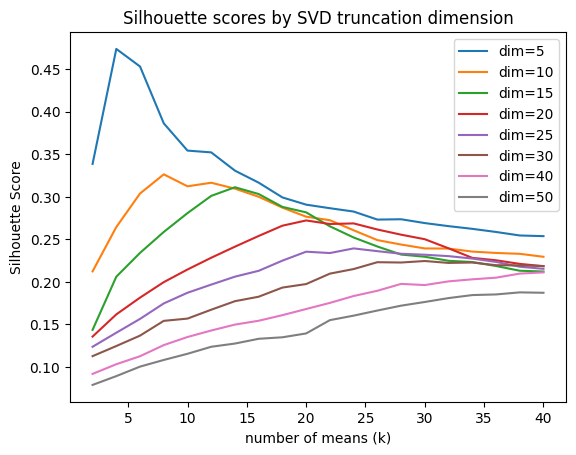

In [143]:
from sklearn.metrics import silhouette_score

TRUNCATED_SVD_DIMS = [5, 10, 15, 20, 25, 30, 40, 50]#,100, 200, 500, 1000, 2000, 5000, 10000]


explained_variances = []
silhouettes = []

for i, dim in enumerate(TRUNCATED_SVD_DIMS):
    silhouettes.append([])
    print(f"Making truncated SVD of dimension {dim}...")
    lsa = make_pipeline(TruncatedSVD(n_components=dim), Normalizer(copy=False))
    X_lsa = lsa.fit_transform(tfidf_proc)
    # print("Truncated SVD complete")
    explained_variance = lsa[0].explained_variance_ratio_.sum()
    explained_variances.append(explained_variance)

    for k in range(2,41,2):
        all_cluster_sizes = []
        sils = []
        for j, seed in enumerate(range(10)):
            #print(f"k={k}, Seed {seed}")
            model = KMeans(
                n_clusters=k,
                max_iter=100,
                n_init=1,
                random_state=seed
            )
            kmeans_lsa = model.fit(X_lsa)
            cluster_ids, cluster_sizes = np.unique(kmeans_lsa.labels_, return_counts=True)
            sil = silhouette_score(X_lsa, model.fit_predict(X_lsa))
            
            #print(f"Sorted: {sorted(cluster_sizes)}")
            sils.append(sil)
            all_cluster_sizes.append(sorted(cluster_sizes))
        sil_bar = np.mean(sils)
        #print(f"Average silhouette score for {dim}-dimension truncated SVD {k}-means: {sil_bar}")
        silhouettes[i].append(sil_bar)
        #print(f"Number of elements assigned to each cluster: {all_cluster_sizes}")
        cluster_variances = np.var(all_cluster_sizes, axis=0)
        #print(f"Cluster size variances:{cluster_variances}")
        #print(f"Sum of cluster size variances: {np.sum(cluster_variances)}")
        #print(f"Mean of cluster size variances: {np.mean(cluster_variances)}")

#print(explained_variances)
#print(silhouettes)
        
# Consulted ChatGPT 3.5 for matplotlib syntax.
def plot_array_of_arrays(dblarr):
    m = len(dblarr)  
    n = len(dblarr[0])  

    color_map = plt.get_cmap('tab10')  
    colors = [color_map(i) for i in range(m)]

    for i in range(m):
        plt.plot(range(2,2+2*n,2), dblarr[i], color=colors[i], label=f'dim={TRUNCATED_SVD_DIMS[i]}')

    plt.xlabel('number of means (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette scores by SVD truncation dimension')
    plt.legend()
    plt.show()

plot_array_of_arrays(silhouettes)

We see here that as the truncated-SVD dimension increases, the silhouette scores of a k-means clustering algorithm go down. This makes sense, given that truncation denoises the data. We also see that for larger dimension, the k at which k-means clustering has a maximum silhouette score tends to be higher. For the first few values of dim, the specific k with peak silhouette score is just under the dimension.

This suggests that a truncation dimension between 5 and 15, and a number k between 5 and 15, are likely to produce relatively distinct and legible topics.

LSA done in 13338.182 s
Explained variance of the SVD step: 9.1%
Cluster 0: strike punched neck wrist takedown resister trr kicked active knee assailant aide lockup pain leg resisting store baton modified lieutenant 
Cluster 1: award aide discharge detention det activate isr failing suspension lockup receipt lieutenant line fired lns timely suspicion locker honorable trr 
Cluster 2: citation ticket plate suspended isr card receipt suspicion registration parking signal expired seatbelt valid cannabis accountabili asks statistical racial award 
Cluster 3: fired gunshot wound great shooting deadly handgun drop fence bullet fled firing gangway pistol lot offi pursuit cer roundtable cartridge 
Cluster 4: taser dog knife deployed discharge inattentive resister handle trigger trr apartment store active properly list lieutenant deployment tased accidentally rank 
Cluster 5: apartment entry team bedroom stair execution domestic basement award narcotic knocked consent hallway entering damage bat

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yellowbrick/cluster/icdm.py:436: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.where(a == np.percentile(a, q, interpolation="nearest"))[0][0]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yellowbrick/cluster/icdm.py:436: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest',

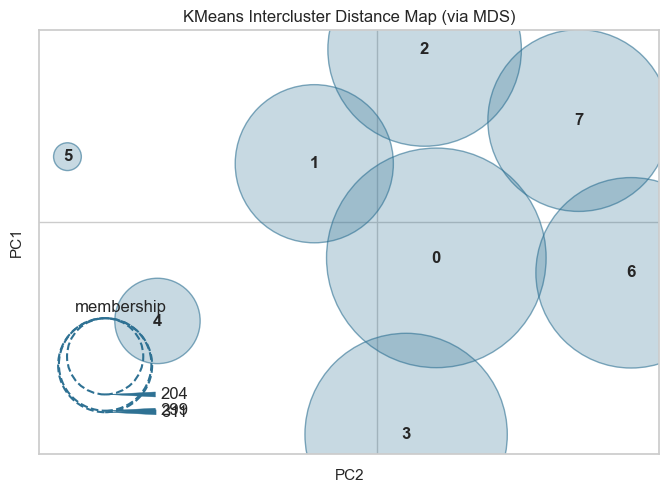

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [160]:
lsa = make_pipeline(TruncatedSVD(n_components=10), Normalizer(copy=False))
X_lsa = lsa.fit_transform(tfidf_proc)
explained_variance = lsa[0].explained_variance_ratio_.sum()

V_T = lsa[0].components_.T #vectors for each word in reduced-dimensional space

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

k=8

for seed in range(5):
    #print(f"\nSeed {seed}")
    kmeans_lsa = KMeans(
        n_clusters=k,
        max_iter=100,
        n_init=1,
        random_state=seed
    ).fit(X_lsa)
    cluster_ids, cluster_sizes = np.unique(kmeans_lsa.labels_, return_counts=True)
    #print(f"Number of elements assigned to each cluster: {cluster_sizes}")
    #print(f"Sorted: {sorted(cluster_sizes)}")

original_space_centroids = lsa[0].inverse_transform(kmeans_lsa.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
    print()

print(kmeans_lsa.labels_)
from collections import Counter 
print(Counter(kmeans_lsa.labels_))

# https://www.scikit-yb.org/en/latest/api/cluster/icdm.html
visualizer = InterclusterDistance(kmeans_lsa)
visualizer.fit(tfidf_proc)        # Fit the data to the visualizer
visualizer.show()  


Observations of note:
- Many of the "closest" words near the front of the list are the same in distinct clusters.
- If you set the TruncatedSVD dimension and k to values at a "peak" in the graph above (e.g. dim=10, k=8), the topic areas are more likely to be clearly separated in the intercluster distance map. With even a little bit of deviation from those "peaks" (e.g. dim=10, k=10), the clusters start to have very serious overlap problems.
- If you generate a new k-means model and intercluster distance map, the clusters are in very noticeably different places, even with the same starting seed. The level of randomness and the general contents of the topics may be mitigated to a large degree by truncated SVD, but it isn't eliminated.

All in all, these observations suggest that truncated-SVD LSA k-means is _not_ an optimal method for topic modeling on this corpus. In fact, any "hard" clustering method, even a lower-variance one, will likely suffer the issues regarding topic overlap, since many of the topics are genuinely similar in concept space. 
A probabilistic clustering method, such as LDA or NMF, is also better for the same reason we decided to do unsupervised learning in the first place -- some documents contain multiple allegations that range across different topics. We want our model to be able to rightly identify not just the dominant topic in a document, but the multiple other topics that the document pertains to. (Probability of belonging to one topic is perhaps an inexact measure of that, as it still assumes an "ideal" document has exactly one topic.)

### Project Wind-Down Takeaways and Ideas for Future Work


Of the topic models tested, their ranking in terms of quality and aptness, assuming the best-tuned hyperparameter values and most apt stopword lists I was able to find during the project timeframe, is as follows:
1) NMF, Kullback-Liebler divergence
2) NMF, Frobenius norm
3) LDA

Then, at more distance:

4) Truncated SVD LSA k-means
5) regular k-means

Then, at further distance still:

6) top2vec
7) BERTopic

On the whole, the tf-idf-based NMF models were the best at producing distinguishable, legible topics, and were able to produce good results for larger numbers of topics (N_COMPONENTS=15 and beyond) without losing much. LDA was similar or better as long as the number of topics remained low, but above about the 7th topic it started to produce very small topics which were either niche (e.g. dog-related incidents) or nonsense. 

As for avenues for future work, these come to mind as high priorities:
- Hierarchical topic modeling and/or clustering: We know this exists, didn't get to setting it up. But it seems like a natural fit for creating a taxonomy of incidents: instead of finding separate topics for gun violence, violence with other weapons, domestic violence, violence involving dogs, etc. a well-tuned hierarchical model might put all such documents under a "violence" supertopic and then split them more finely at a lower level of the hierarchy.
- More aggressive and/or targeted removal of stopwords, including report procedure words that are common in reports across a wide variety of topics, and/or plugging in results from NER to more accurately remove te names that are actually in these documents
- Checking for more overlap below the top 30 words of topic lists, to see if the bulk of topics actually have more muddle or mixture than the most predictive words would suggest (perhaps using a word-topic matrix to find the words most likely to be in multiple topics)
- A better way to find "fuzzy" documents that do not have one predominant topic, or that have a relatively even likelihood of belonging to multiple distinct topics (this could involve searching for documents where no probability is above 50%, and possibly using softmax or logistic regression on "raw" outputs of document-term matrix to produce more mathematically sound multi-topic scores)